<a href="https://colab.research.google.com/github/waitaminutewhoareyou/Benchmark-Futures-Model/blob/main/Benchmark_Model_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This report documents methodologies and findings during benchmark model research

# Architecture

The pipeline that yields benchmark models concist of three components


1.   Dataloader
     - This component screens,cleans, and output the data into a three dimensional array.
     - Such 3D data is difficult to visualize via csv file, so it is saved as .pkl  
     - ```sh
                          Asset 1   Asset 2   Asset 3
        Day 1 Feature 1    xx        xx        xx
              Feature 2    xx        xx        xx
              Feature 3    xx        xx        xx

        Day 2 Feature 1    xx        xx        xx
              Feature 2    xx        xx        xx
              Feature 3    xx        xx        xx
        ```
     - Read auxiliary information, such as leverage, sector indicator etc.  
2.   Singal generation
     - Read the .pkl, and generate daily weight as instructed by the benchmark algorithm, multiply the weight on the (transfomred) return, and then output the return series

3.   Backtest
     - Take the return series and output relevant statsitcs such as Sharpe ratio, maximum drawdown.







In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

drive.mount('/content/drive')
root_dir = "/content/drive/My Drive/Quant Research/Benchmark Models/" 
%cd "/content/drive/My Drive/Quant Research/Benchmark Models/" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Quant Research/Benchmark Models


In [ ]:


class BackTest:
    def __init__(self, data, start_time=None, end_time=None):

        data = data.squeeze()
        data = data[start_time:end_time]
        self.data = data.dropna(
        )
        self.time_freq = pd.infer_freq(data.index)

        if self.time_freq == 'B' or self.time_freq == 'D':
            self.T = 250
            self.monthly_return = data.resample('M').agg(lambda x: (x + 1).prod() - 1)
            self.time_freq = 'D'  # reset business day frequency to daily frequency

        elif self.time_freq == 'M':
            self.T = 12
            self.monthly_return = data

        else:
            print("Can't detect time frequency. Using daily frequency by default. ")
            self.T = 250
            self.monthly_return = data.resample('M').agg(lambda x: (x + 1).prod() - 1)
            self.time_freq = 'D'  # reset business day frequency to daily frequency
             #raise Exception("Can't detect time frequency")

        self.AUM = (1 + self.monthly_return).cumprod()
        self.dd = 1 - self.AUM / np.maximum.accumulate(self.AUM)

    def total_return(self):
        return np.prod(1 + self.data.values) - 1

    def annualized_return(self):
        return (1 + self.total_return()) ** (self.T / len(self.data)) - 1

    def annualized_volatility(self):
        return np.std(self.data.values) * np.sqrt(self.T)

    def information_ratio(self):
        ret = self.annualized_return()
        vol = self.annualized_volatility()
        return ret / vol

    def compute_drawdown_duration_peaks(self, dd: pd.Series):
        iloc = np.unique(np.r_[(dd == 0).values.nonzero()[0], len(dd) - 1])
        iloc = pd.Series(iloc, index=dd.index[iloc])
        df = iloc.to_frame('iloc').assign(prev=iloc.shift())
        df = df[df['iloc'] > df['prev'] + 1].astype(int)


        # If no drawdown since no trade, avoid below for pandas sake and return nan series
        if not len(df):
            return (dd.replace(0, np.nan),) * 2

        df['duration'] = df['iloc'].map(dd.index.__getitem__) - df['prev'].map(dd.index.__getitem__)
        df['peak_dd'] = df.apply(lambda row: dd.iloc[row['prev']:row['iloc'] + 1].max(), axis=1)
        df = df.reindex(dd.index)
        return df['duration'], df['peak_dd']

    def under_water_time(self):
        df = self.data.to_frame()
        df['Return'] = df.values
        df['cummax'] = df['Return'].cummax()

        df['underwater'] = pd.to_timedelta((df['Return'] < df['cummax']).astype(int), unit=self.time_freq)
        total_time_under_water = df['underwater'].sum()

        time_under_water, max_time_under_water = 0, 0

        # loop through an Boolean series
        for val in (df['Return'] < df['cummax']).astype(int).values:
            time_under_water = time_under_water + 1 if val else 0
            max_time_under_water = max(time_under_water, max_time_under_water)

        # for display purpose
        max_time_under_water = pd.to_timedelta(max_time_under_water, unit=self.time_freq)

        return max_time_under_water, total_time_under_water

    def max_drawdown_one_month(self):
        monthly_negative_return = self.monthly_return[self.monthly_return < 0]
        return monthly_negative_return.min()

    def compute_stat(self, title=None):
        equity = self.AUM.values
        index = self.data.index
        dd = self.dd
        dd = 1 - equity / np.maximum.accumulate(self.AUM)
        # dd_dur, dd_peaks = self.compute_drawdown_duration_peaks(pd.Series(dd, index=index))
        dd_dur, dd_peaks = self.compute_drawdown_duration_peaks(dd)

        s = pd.Series(dtype=object)
        s.loc['Start'] = index[0]
        s.loc['End'] = index[-1]
        s.loc['Duration'] = s.End - s.Start

        s.loc['Return (Ann.) [%]'] = self.annualized_return() * 100
        s.loc['Volatility (Ann.) [%]'] = self.annualized_volatility() * 100
        s.loc['Information Ratio'] = self.information_ratio()

        s.loc['Final AUM [unitless]'] = equity[-1]
        s.loc['AUM Peak [$]'] = equity.max()
        s.loc['Final Return [%]'] = (equity[-1] - equity[0]) / equity[0] * 100
        max_dd = -np.nan_to_num(dd.max())
        s.loc['Max. Drawdown [%]'] = max_dd * 100
        s.loc['Max. Drawdown Duration'] = dd_dur.max()
        s.loc['Avg. Drawdown Duration'] = dd_dur.mean()

        max_time_under_water, total_time_under_water = self.under_water_time()
        s.loc['Max. Underwater Duration'] = max_time_under_water
        s.loc['Total Underwater Duration'] = total_time_under_water
        self.AUM.plot(title=title)
        plt.grid(True)
        plt.show()
        return s

# Dataloading

The dataset consists of 114 futures asset, indexed by HCM id from 1 - 135.

Auxiliary files include asset specs.csv which provides sector indicator information.

Date range: *End of 1970 to end of 2021*

Though the avaialble data traces back to last century, we remove data before 2015 and only backtest during 2015 - 2020 for relevance and saving computational time.



Features used include
- **Name** - Most active contract
- **Cur** - Currency
- **Year Month Day** - Timestamp
- **%change** - Unadjusted daily return
- **Vol** - Volume
- **Px** - Settlement price
- **FxBase** - 0 if USD based, otherwise 1
- **sector indicator** - Fx, Commodity, Equity and Bond


## Dataset

We loop through 114 csv files. Append Fx-ajusted return as a new column, and stack all csv files into a 3d array.

This part is already done by data_loader.py and the consoliadted table is saved as a pickle, we simply load it.

and set the appropriate time range.

In [ ]:
data_dir = root_dir + 'Data/'
df = pd.read_pickle(data_dir + 'consolidated_table')

start_date = '2016-12-10'
end_date = '2022-01-01'
data = df.loc[start_date:]
data

1            2           3    ...     131    134     135
Date       Features                                       ...                       
2016-12-10 Name             NaN          NaN         NaN  ...     NaN    NaN     NaN
           Cur              NaN          NaN         NaN  ...     NaN    NaN     NaN
           Year            2016         2016        2016  ...    2016   2016    2016
           Month             12           12          12  ...      12     12      12
           Day               10           10          10  ...      10     10      10
...                         ...          ...         ...  ...     ...    ...     ...
2021-12-17 Vol           112025        93829      104577  ...   85846   3997    4381
           Px             98.36       98.745      143.61  ...   17019  702.5   46250
           Fx            0.7125       0.7125      1.2889  ...       1      1       1
           FxBase             0            0           1  ...       1      1       1
           ret      -0.00119124  0.000138256  0.00188319  ... -0.0178  0.001 -0.0367

[20174 rows x 113 columns]

## Asset Specs

Load the sector indicator and maximum available leverage

In [ ]:
asset_specs = pd.read_csv(data_dir + "asset_spec.csv", index_col=['Asset number']).sort_index()
asset_specs

,Asset name,Illiquid,Max lev,Adjustment,New,Base,Eur Overwrite,Equity indicator,Bond indicator,Comm indicator,FX indicator,EM indicator,NA indicator,EU indicator,Broker code
Asset number,,,,,,,,,,,,,,,
1,Australia 10-year,0,20,2.0,0,0,0,0,1,0,0,0,0,0,3
2,Australia 3-year,0,20,2.0,0,0,0,0,1,0,0,0,0,0,3
3,Canada 10-year,0,20,2.0,0,1,0,0,1,0,0,0,1,0,3
4,Germany BOBL,0,20,2.0,0,1,1,0,1,0,0,0,0,1,3
5,Germany BUND,0,20,2.0,0,1,1,0,1,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,India CNX Nifty SG,0,10,1.2,0,1,0,1,0,0,0,1,0,0,3
134,MSCI Taiwan,1,10,1.2,1,1,0,1,0,0,0,1,0,0,3
135,BTC,1,1,0.3,0,1,0,0,0,0,1,0,0,0,3


In [ ]:
liquid_asset = [asset for asset in data.columns if asset_specs.loc[asset, 'Illiquid']==0]
data = data[liquid_asset]

# Methodology

Most of the the benchmark models share the following similarities


*   Estimate volatility based on past one year standard deviation.
   * Such estimation is agnostic to the permuation of daily standard devation,
   perhapes we could apply a weight decay to the time sereis of standard deviation.
  


*   Amplify the raw Fx-adjusted return by a leverage, which will set the asset's volatily to 30% (capped by max leverage shown in asset pecs).

It is convinent to define a parent class *RiskParity* that encodes such similarities, and each benchmark model would inherit the parent class and definies its own signal generation process.

In [ ]:
class RiskParity:
  def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252):
    self.ret = raw_data.xs("ret", level='Features')
    self.leverage = asset_specs['Max lev']
    self.N = N
    self.vol_target = vol_target 
    self.asset_specs = asset_specs.loc[self.ret.columns, :]
  
  def rolling_std(self):
    return self.ret.rolling(self.N, min_periods=2).std().shift(1) * np.sqrt(self.N)
  
  def compute_leverage(self):


    def _cap_leverage(column):
      return np.minimum(column, self.leverage.loc[column.name])
    
    rolling_table = self.rolling_std()
    leverage_table = self.vol_target/rolling_table
    leverage_table = leverage_table.apply(_cap_leverage) 
    return leverage_table
  
  def transform_ret(self):
    leverage_table = self.compute_leverage()
    return self.ret.multiply(leverage_table, axis=0)

  def visualize_return(self, ret):
    ax, fig = plt.subplots()
    ret = ret.dropna()
    ax = (1+ret).cumprod().plot()
    plt.title('Simple risk parity')
    plt.grid()
    plt.show()  

## Simple Risk Parity

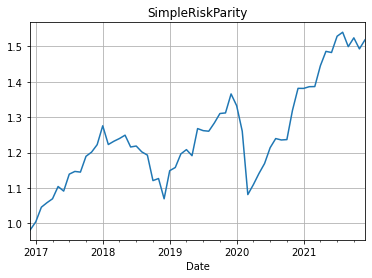

Start                        2016-12-14 00:00:00
End                          2021-12-17 00:00:00
Duration                      1829 days 00:00:00
Return (Ann.) [%]                        8.33365
Volatility (Ann.) [%]                    10.9477
Information Ratio                       0.761227
Final AUM [unitless]                     1.51867
AUM Peak [$]                              1.5401
Final Return [%]                         54.7493
Max. Drawdown [%]                       -20.8305
Max. Drawdown Duration         607 days 00:00:00
Avg. Drawdown Duration         191 days 00:00:00
Max. Underwater Duration       770 days 00:00:00
Total Underwater Duration     1297 days 00:00:00
dtype: object

In [ ]:
class SimpleRiskParity(RiskParity):
    def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252):
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret()

    def compute_return(self):
        return self.transformed_ret.mean(axis=1)


srp = SimpleRiskParity(data, asset_specs)
ret = srp.compute_return()
SimpleRiskParity = BackTest(ret).compute_stat('SimpleRiskParity')
SimpleRiskParity

## Asset Class Parity

### Four Sectors

Can't detect time frequency. Using daily frequency by default. 


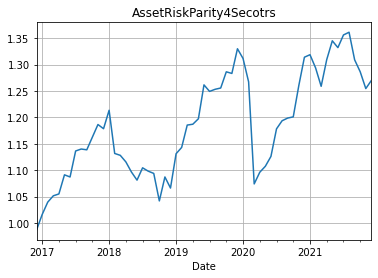

Start                        2016-12-15 00:00:00
End                          2021-12-17 00:00:00
Duration                      1828 days 00:00:00
Return (Ann.) [%]                         6.0413
Volatility (Ann.) [%]                    11.1269
Information Ratio                       0.542945
Final AUM [unitless]                      1.2698
AUM Peak [$]                              1.3611
Final Return [%]                         28.6876
Max. Drawdown [%]                       -19.2479
Max. Drawdown Duration         517 days 00:00:00
Avg. Drawdown Duration         175 days 21:20:00
Max. Underwater Duration       614 days 00:00:00
Total Underwater Duration     1009 days 00:00:00
dtype: object

In [ ]:
class AssetRiskParity(RiskParity):
    def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252, 
                 sector_names =['Equity indicator', 'Bond indicator', 'Comm indicator', 'FX indicator'] ):
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret().dropna()
      self.sector_classifier = self.asset_specs[sector_names]
    

    def compute_return(self):
      risk_parity_return = self.transformed_ret
      weights = self.sector_classifier / self.sector_classifier.sum(axis=0)
      num_sectors = self.sector_classifier.shape[1]
      weights = 1 / num_sectors * weights.sum(axis=1) 
      assert abs(weights.sum() - 1) < 1e-4, 'Sector weights overflow'

      return pd.Series(data =risk_parity_return.values @ weights.values, index=risk_parity_return.index )

acrp = AssetRiskParity(data, asset_specs)
ret = acrp.compute_return()
AssetRiskParity4Secotrs = BackTest(ret).compute_stat('AssetRiskParity4Secotrs')
AssetRiskParity4Secotrs

### Three Sectors

Can't detect time frequency. Using daily frequency by default. 


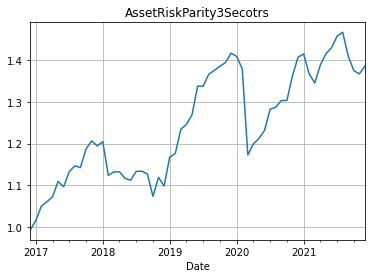

Start                        2016-12-15 00:00:00
End                          2021-12-17 00:00:00
Duration                      1828 days 00:00:00
Return (Ann.) [%]                        8.33825
Volatility (Ann.) [%]                    10.6941
Information Ratio                       0.779703
Final AUM [unitless]                     1.38558
AUM Peak [$]                             1.46606
Final Return [%]                         39.4642
Max. Drawdown [%]                       -17.1715
Max. Drawdown Duration         547 days 00:00:00
Avg. Drawdown Duration         255 days 09:36:00
Max. Underwater Duration       599 days 00:00:00
Total Underwater Duration     1008 days 00:00:00
dtype: object

In [ ]:
asset_specs_four_sectors = pd.read_csv('Archived/asset_spec_archived.csv').sort_values('Asset number').set_index('Asset number')
acrp = AssetRiskParity(data, asset_specs_four_sectors,sector_names=['Equity indicator','Bond indicator', 'Others indicator'])
ret = acrp.compute_return()
AssetRiskParity3Secotrs = BackTest(ret).compute_stat('AssetRiskParity3Secotrs')
AssetRiskParity3Secotrs

## Volume-Weighted Risk Parity

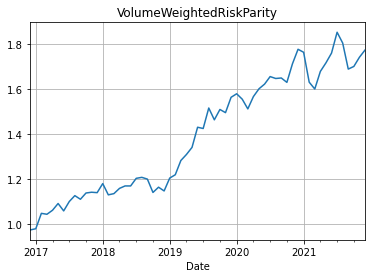

Start                        2016-12-10 00:00:00
End                          2021-12-17 00:00:00
Duration                      1833 days 00:00:00
Return (Ann.) [%]                        8.11454
Volatility (Ann.) [%]                    9.82617
Information Ratio                        0.82581
Final AUM [unitless]                     1.77245
AUM Peak [$]                             1.85151
Final Return [%]                         81.8369
Max. Drawdown [%]                       -9.92218
Max. Drawdown Duration         212 days 00:00:00
Avg. Drawdown Duration         116 days 14:00:00
Max. Underwater Duration       824 days 00:00:00
Total Underwater Duration     1818 days 00:00:00
dtype: object

In [ ]:
class VolumeWeightedRiskParity(RiskParity):
    def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252):
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret()
      self.volume_df = raw_data.xs("Vol", level='Features').shift(1).dropna(axis=0, how='all')


    
    def compute_return(self):
      weights_df = self.volume_df.div(self.volume_df.sum(axis=1), axis=0)
      return self.transformed_ret.multiply(weights_df, axis=0).sum(axis=1)

vwrp = VolumeWeightedRiskParity(data, asset_specs)
ret = vwrp.compute_return()
VolumeWeightedRiskParityResult = BackTest(ret).compute_stat('VolumeWeightedRiskParity')
VolumeWeightedRiskParityResult

## Adjusted Volume-Weighted Risk Parity

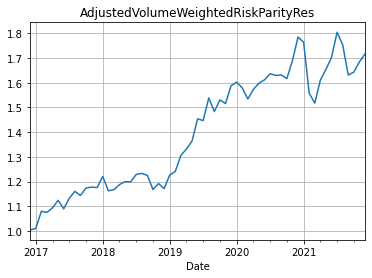

Start                        2016-12-10 00:00:00
End                          2021-12-17 00:00:00
Duration                      1833 days 00:00:00
Return (Ann.) [%]                        7.64337
Volatility (Ann.) [%]                    9.93503
Information Ratio                       0.769336
Final AUM [unitless]                     1.71656
AUM Peak [$]                             1.80396
Final Return [%]                         70.8814
Max. Drawdown [%]                       -14.9724
Max. Drawdown Duration         212 days 00:00:00
Avg. Drawdown Duration         119 days 02:00:00
Max. Underwater Duration       824 days 00:00:00
Total Underwater Duration     1816 days 00:00:00
dtype: object

In [ ]:
class AdjustedVolumeWeightedRiskParity(RiskParity):
    def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252):
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret()
      self.volume_df = raw_data.xs("Vol", level='Features').shift(1).dropna(axis=0, how='all')
      self.matrix = raw_data 

    
    def compute_return(self):
      ret_df = self.transformed_ret 

      rolling_std_df = ret_df.shift(1).rolling(self.N, min_periods=2).apply(np.nanstd) * np.sqrt(
        self.N)
      
      rolling_lev = self.vol_target / rolling_std_df

      volume_df = self.matrix.xs("Vol", level='Features').shift(1)

      adjusted_volume = volume_df.divide(rolling_lev, axis=0)

      
      scaling_factor_df = (1 / adjusted_volume.sum(axis=1)).replace([np.inf, -np.inf], np.nan)

      weights_df = self.volume_df.multiply(scaling_factor_df, axis=0)

      return self.transformed_ret.multiply(weights_df, axis=0).sum(axis=1)

avwrp = AdjustedVolumeWeightedRiskParity(data, asset_specs)
ret = avwrp.compute_return()
AdjustedVolumeWeightedRiskParityRes = BackTest(ret).compute_stat("AdjustedVolumeWeightedRiskParityRes")
AdjustedVolumeWeightedRiskParityRes

## Momentum Risk Parity

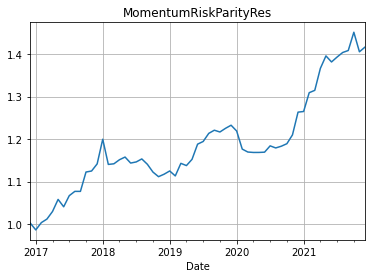

In [ ]:
class MomentumRiskParity(RiskParity):
  def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252, 
                 sector_names =['Equity indicator', 'Bond indicator', 'Comm indicator', 'FX indicator'] ):
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret()
      

  def cumulative_return(self,x):
    return (1+x).prod() - 1

  def momentumQ(self, x):
    return 1 if self.cumulative_return(x) > 0 else 0 

  def momentum_rolling(self): 
    binary_table = self.transformed_ret.shift(1).rolling(self.N, min_periods=2).apply(self.momentumQ)
    return  binary_table.fillna(0) # rolling include current row
  
  def filtered_return_table(self):
    filter_table = self.momentum_rolling()
    filtered_return_table = pd.DataFrame(self.transformed_ret.values * filter_table.values, 
                                         columns=self.transformed_ret.columns, 
                                         index=self.transformed_ret.index)
    return filtered_return_table

  def compute_return(self):
    ret = self.filtered_return_table()
    return ret.mean(axis=1)

mrp = MomentumRiskParity(data, asset_specs)
ret = mrp.compute_return()
MomentumRiskParityRes = BackTest(ret).compute_stat('MomentumRiskParityRes')
MomentumRiskParityRes

## Momentum Risk Parity by Asset Class

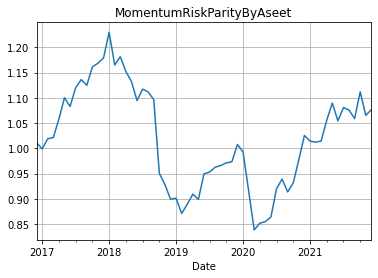

Start                        2016-12-16 00:00:00
End                          2021-12-17 00:00:00
Duration                      1827 days 00:00:00
Return (Ann.) [%]                        1.01855
Volatility (Ann.) [%]                    9.85649
Information Ratio                       0.103338
Final AUM [unitless]                     1.07691
AUM Peak [$]                             1.23004
Final Return [%]                         6.48277
Max. Drawdown [%]                       -31.8254
Max. Drawdown Duration        1430 days 00:00:00
Avg. Drawdown Duration         402 days 18:00:00
Max. Underwater Duration       634 days 00:00:00
Total Underwater Duration     1819 days 00:00:00
dtype: object

In [ ]:
class MomentumRiskParityByAseet(MomentumRiskParity):
  def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252, 
                 sector_names =['Equity indicator', 'Bond indicator', 'Comm indicator', 'FX indicator'] ):
      MomentumRiskParity.__init__(self, raw_data, asset_specs, vol_target, N)
      self.transformed_ret = self.transform_ret()
      self.sector_classifier = self.asset_specs[sector_names]

  def compute_return(self):
    # matrix multiplication of return matrix and sector indicator,
    filtered_return_table = self.filtered_return_table()
    ret = pd.DataFrame(filtered_return_table.fillna(0).values @ self.sector_classifier.values,
                       index=filtered_return_table.index,
                       columns = self.sector_classifier.columns)

    # average within asset class
    mask = self.momentum_rolling()
    count_mat = pd.DataFrame(mask.values @ self.sector_classifier.values,
                       index = mask.index,
                       columns = self.sector_classifier.columns).replace(0, np.nan) # replace 0 by nan to avoid division by zero

    ret = ret.div(count_mat)

    return ret.mean(axis=1,skipna=True)

mrp_by_asset = MomentumRiskParityByAseet(data, asset_specs)
ret = mrp_by_asset.compute_return()
MomentumRiskParityByAseetRes = BackTest(ret).compute_stat('MomentumRiskParityByAseet')
MomentumRiskParityByAseetRes

## Momentum Risk Parity with Softmax Activation

At each time period, this benchmark filters asset by its momentum, then using sharpe ratio of the current lookback period, apply a softmax function to the sharpe ratio vector, yield a weight vector.

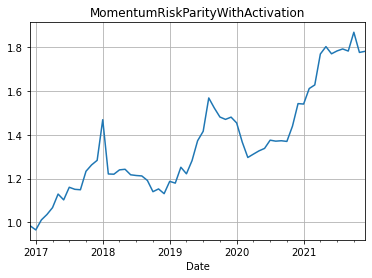

Start                                2016-12-10 00:00:00
End                                  2021-12-17 00:00:00
Duration                              1833 days 00:00:00
Return (Ann.) [%]                                  8.184
Volatility (Ann.) [%]                             11.708
Information Ratio                               0.699011
Final AUM [unitless]                             1.78082
AUM Peak [$]                                     1.86804
Final Return [%]                                 81.0108
Max. Drawdown [%]                               -23.0035
Max. Drawdown Duration                 577 days 00:00:00
Avg. Drawdown Duration       221 days 10:17:08.571428572
Max. Underwater Duration              1421 days 00:00:00
Total Underwater Duration             1821 days 00:00:00
dtype: object

In [ ]:
from scipy.special import softmax
class MomentumRiskParityWithActivation(RiskParity):
  def __init__(self, raw_data, 
               asset_specs, 
               vol_target=0.3, 
               N=252, 
                sector_names =['Equity indicator', 'Bond indicator', 'Comm indicator', 'FX indicator'] ):
      
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret()
  
  @staticmethod
  def filtered_return(ret):
    ret.dropna(inplace=True)
    net_ret = ret.mean() / ret.std() * np.sqrt(252) if (1+ret).prod()>1 else 0
    return  net_ret
  
  def compute_return(self):
    weights = self.transformed_ret.shift(1).rolling(self.N, min_periods=1).apply(MomentumRiskParityWithActivation.filtered_return).fillna(0)
    weights = weights.apply(softmax, axis=1)

    ret =self.transformed_ret.multiply(weights).sum(axis=1)

    return ret

MMT_activation =  MomentumRiskParityWithActivation(data, asset_specs)
ret = MMT_activation.compute_return()
MomentumRiskParityWithActivationRes = BackTest(ret).compute_stat('MomentumRiskParityWithActivation')
MomentumRiskParityWithActivationRes

## Volume-Weighted Momentum Risk Parity

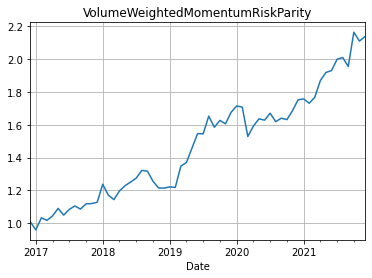

Start                        2016-12-10 00:00:00
End                          2021-12-17 00:00:00
Duration                      1833 days 00:00:00
Return (Ann.) [%]                        10.9026
Volatility (Ann.) [%]                    12.0831
Information Ratio                       0.902306
Final AUM [unitless]                     2.13645
AUM Peak [$]                             2.16257
Final Return [%]                          111.51
Max. Drawdown [%]                       -10.8455
Max. Drawdown Duration         335 days 00:00:00
Avg. Drawdown Duration         111 days 06:00:00
Max. Underwater Duration       637 days 00:00:00
Total Underwater Duration     1817 days 00:00:00
dtype: object

In [ ]:
class VolumeWeightedMomentumRiskParity(RiskParity):
  def __init__(self, raw_data, asset_specs, vol_target=0.3, N=252, 
                 sector_names =['Equity indicator', 'Bond indicator', 'Comm indicator', 'FX indicator'] ):
      RiskParity.__init__(self, raw_data, asset_specs, vol_target=0.3, N=252)
      self.transformed_ret = self.transform_ret()
      self.filter_table = self.momentum_rolling()
      self.volume_df = raw_data.xs("Vol", level='Features').shift(1)

  def cumulative_return(self,x):
    return (1+x).prod() - 1

  def momentumQ(self, x):
    return 1 if self.cumulative_return(x) > 0 else 0 

  def momentum_rolling(self): 
    binary_table = self.transformed_ret.shift(1).rolling(self.N, min_periods=2).apply(self.momentumQ)
    return  binary_table.fillna(0) # rolling include current row


  def filtered_return_table(self):

    filtered_return_table = pd.DataFrame(self.transformed_ret * self.filter_table.values, 
                                         columns=self.transformed_ret.columns, 
                                         index=self.transformed_ret.index)
    return filtered_return_table


  def filtered_volume_table(self):

    filtered_volume_table = pd.DataFrame(self.volume_df.values * self.filter_table.values, 
                                         columns=self.volume_df.columns, 
                                         index=self.volume_df.index).dropna(axis=0, how='all')
    return filtered_volume_table
  def compute_return(self):
    ret = self.filtered_return_table()
    vol = self.filtered_volume_table()
    total_vol = vol.sum(axis=1)
    weights = vol.div(total_vol[total_vol != 0], axis=0)
    return ret.multiply(weights).sum(axis=1)

vmrp = VolumeWeightedMomentumRiskParity(data, asset_specs)
ret = vmrp.compute_return()
VolumeWeightedMomentumRiskParityRes = BackTest(ret).compute_stat('VolumeWeightedMomentumRiskParity')
VolumeWeightedMomentumRiskParityRes

# Result

In [ ]:
res = pd.concat([SimpleRiskParity.rename('SimpleRP') ,
                 AssetRiskParity4Secotrs.rename('AssetRP4Secotrs'),
                 AssetRiskParity3Secotrs.rename('AssetRP3Secotrs'),
                 VolumeWeightedRiskParityResult.rename('VolWeightedRP'),
                 AdjustedVolumeWeightedRiskParityRes.rename('AdjVolWeightedRP'),
                 MomentumRiskParityRes.rename(' MomentumRP'),
                 MomentumRiskParityByAseetRes.rename('MomentumRPByAsset'),
                 MomentumRiskParityWithActivationRes.rename('MomentumRPWithActivation'),
                 VolumeWeightedMomentumRiskParityRes.rename(' VolWeightedMomentumRP')], axis=1)


In [ ]:
def formatter(x):
  if isinstance(x, float):
    return str(round(x, 2))
  elif isinstance(x, pd._libs.tslibs.timedeltas.Timedelta):
    return x.days
  elif isinstance(x, pd._libs.tslibs.timestamps.Timestamp):
    return x.strftime('%Y-%m-%d')

def highlight_max(s):
    if s.name in ['Start', 'End','Duration' ]:
      return ['' for _ in range(len(s))]

    is_max = s == s.max()
    color_scheme = []
    for cell in range(len(s)):
      if s.iloc[cell] == s.max():
        color_scheme.append('background: coral')
      elif s.iloc[cell] == s.min():
        color_scheme.append('background: lightgreen')
      else:
        color_scheme.append('')
    return color_scheme

d = dict(selector="th",
    props=[('text-align', 'center')])

res.applymap(formatter).style.apply(highlight_max,axis=1).set_properties(**{'width':'5em', 'text-align':'center'})\
        .set_table_styles([d])

,SimpleRP,AssetRP4Secotrs,AssetRP3Secotrs,VolWeightedRP,AdjVolWeightedRP,MomentumRP,MomentumRPByAsset,MomentumRPWithActivation,VolWeightedMomentumRP
Start,2016-12-14,2016-12-15,2016-12-15,2016-12-10,2016-12-10,2016-12-14,2016-12-16,2016-12-10,2016-12-10
End,2021-12-17,2021-12-17,2021-12-17,2021-12-17,2021-12-17,2021-12-17,2021-12-17,2021-12-17,2021-12-17
Duration,1829,1828,1828,1833,1833,1829,1827,1833,1833
Return (Ann.) [%],8.33,6.04,8.34,8.11,7.64,6.89,1.02,8.18,10.9
Volatility (Ann.) [%],10.95,11.13,10.69,9.83,9.94,6.62,9.86,11.71,12.08
Information Ratio,0.76,0.54,0.78,0.83,0.77,1.04,0.1,0.7,0.9
Final AUM [unitless],1.52,1.27,1.39,1.77,1.72,1.42,1.08,1.78,2.14
AUM Peak [$],1.54,1.36,1.47,1.85,1.8,1.45,1.23,1.87,2.16
Final Return [%],54.75,28.69,39.46,81.84,70.88,41.23,6.48,81.01,111.51
Max. Drawdown [%],-20.83,-19.25,-17.17,-9.92,-14.97,-7.33,-31.83,-23.0,-10.85


The maximum value in each metric is highlighted by coral.
The minimum value in each metric is hilighted by lightgreen.